# Проект классификации комментариев на токсичность NLP

Интернет-магазин запускает новый сервис. Пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучиим модели для классификации комментариев на позитивные и негативные.   
В вашем распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`.

Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
!pip install nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from pymystem3 import Mystem
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
try: 
    data = pd.read_csv("toxic_comments.csv")
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
def df_info(df, title):
    print()
    print('\033[1m' + ''.join(title) +'\033[0m')
    display(df.head(5))
    print()
    print('Размер данных', title)
    display(df.shape)    
    print()    
    print('Общая информация о', title) 
    print()
    display(df.info())
    print('Пропуски в', title) 
    report = df.isna().sum().to_frame().rename(columns = {0: 'missing_values'})
    report['% of total'] = ((report['missing_values'] / data.shape[0]).round(2))*100
    display(report.sort_values(by = 'missing_values', ascending = False))
    print()
    print('Полных дубликатов в', title, df.duplicated().sum())
    print()    
    print('Баланс классов в', title)
    class_ratio = data['toxic'].value_counts().to_frame().rename(columns = {'toxic': 'class_count'})
    class_ratio['% of total'] = round(((data['toxic'].value_counts()/ len(df))*100), 2)
    display(class_ratio)
       
df_info(data,'data')


data


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0



Размер данных data


(159292, 3)


Общая информация о data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

Пропуски в data


,missing_values,% of total
Unnamed: 0,0,0.0
text,0,0.0
toxic,0,0.0



Полных дубликатов в data 0

Баланс классов в data


,class_count,% of total
0,143106,89.84
1,16186,10.16


**Наблюдения:**

Данные из 159571 комментариев без пропусков и дублей. Дубли ещё перепроверим после того, как приведем всё к нижнему регистру и уберём пунктуацию.  
Типы соответсвуют данным.  
Обнаружен дисбаланс классов практически 9:1. С ним будем бороться на уровне настройки весов классов для моделей. 

Очистим комментарии от символов пунктуации и приведём всё в нижний регистр.

In [4]:
def clean_data(row):
    row = re.sub(r'(?:\n|\r)', ' ', row)
    row = re.sub(r'[^a-zA-Z ]+', '', row).strip()
    row = row.lower()
    return row

data['text'] = data['text'].apply(clean_data)
data.head()

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,daww he matches this background colour im seem...,0
2,2,hey man im really not trying to edit war its j...,0
3,3,more i cant make any real suggestions on impro...,0
4,4,you sir are my hero any chance you remember wh...,0


Перепроверим дубли

In [5]:
display(data.duplicated().sum())

0

Дубли всё таки есть. Удаляем!

In [6]:
data = data.drop_duplicates()
data.shape

(159292, 3)

Лемаизируем с `nltk` и pos-тегами.   
Выполнение кода минут на 15. Можно сходить заварить чайку)

In [7]:
tag_dict = {"J": wordnet.ADJ,"N": wordnet.NOUN,"V": wordnet.VERB, "R": wordnet.ADV}

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)

stopwords = set(stopwords.words('english'))

def lemmatized(text):
    word_list = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    without_stopwords = [word for word in word_list if not word in stopwords]
    return " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in without_stopwords])
 
data['text'] = data['text'].apply(lemmatized)

Подготовим фичи и целевой признак перед обучением. Подбирать гиперпараметры будем через `GridSearchCV` c  кросс-валидациейп, потому делить будем только на трейн и тест.

In [8]:
features = data.drop(['toxic'], axis=1)
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, stratify=target,
                                                                            test_size=0.2,
                                                                            random_state=12345)

Оценим важность слов с помощью `TF-IDF` для дальнейшего анализа тональности комментариев

In [9]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords,ngram_range=(1,1))

tf_idf_train = count_tf_idf.fit_transform(features_train['text'])
tf_idf_test = count_tf_idf.transform(features_test['text'])

print('Трейн ', tf_idf_train.shape)
print('Тест  ',tf_idf_test.shape)

Трейн  (127433, 177278)
Тест   (31859, 177278)


### Вывод

Подготовили данные, убрав регистр и знаки пунктуации. После этого этапа выявили дубли, от которых избавились. 
Разбили данные на обучающую и тестувую выборки. Гиперпараметры моделей будем подбирать через кросс-валидацию, поэтому эту выборку не выделяем.
Для определения тональности будем применять величины TF-IDF как признаки. Расчитали их для  комментариев. 


## Обучение

Признаков много. От классических деревянных моделей откажемся в пользу более эффективных.   
Выберем для исследования 2 типа моделей классификации: LogisticRegression и градиентный бустинг LGBMClassifier.  
Создадим фрейм, куда собирём результаты.   
Диапазон подбора гиперпараметров уже сузил, чтобы не занимать длительное время на подбор, так как проходился предварительно по более широкому. 

In [10]:
column = ['model','F1_valid','F1_test']
results = pd.DataFrame(columns=column)

### LogisticRegression

In [11]:
lr = LogisticRegression(random_state=12345, class_weight='balanced', solver='liblinear')

# гиперпараметры для первоначального подбора. Оставил ниже лучшие.
# params = {'C': np.arange(1,9,2)} 
params = {'C': [5]}

lr_gs = GridSearchCV(lr, params, cv=4, scoring='f1', verbose=True).fit(tf_idf_train, target_train)
lr_gs.best_estimator_.fit(tf_idf_train, target_train)
lr_predict_test = lr_gs.best_estimator_.predict(tf_idf_test)
lr_f1_test = f1_score(target_test, lr_predict_test)

print ("Лучшие параметры", lr_gs.best_params_)
print ("F1_valid", lr_gs.best_score_)
print ("F1_test", lr_f1_test)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
Лучшие параметры {'C': 5}
F1_valid 0.7602862763404424
F1_test 0.7626568890142433


Заносим результаты

In [12]:
results = pd.concat([results, pd.DataFrame([['LogisticRegression', round(lr_gs.best_score_, 4), 
                                             round(lr_f1_test, 4)]], columns=column)])          

### LGBMClassifier

Тут тоже оставил уже лучшие гиперпараметры, но обучается модель в JupiterHub очень долго, в GoogleColab минут 16 всего. 

In [13]:
lgbm = lgb.LGBMClassifier(objective='binary', class_weight='balanced', n_jobs = -1)

# гиперпараметры для первоначального подбора. Оставил ниже лучшие.
# param_grid = {'max_depth': np.arange(10, 60, 10),
#              'n_estimators': np.arange(100, 600, 100)}
 
param_grid = {'max_depth': [30],
              'n_estimators': [300]}

lrgb_gs = GridSearchCV(lgbm, param_grid = param_grid, cv=4, scoring='f1').fit(tf_idf_train, target_train)
lrgb_gs.best_estimator_.fit(tf_idf_train, target_train)
lrgb_predict_test = lrgb_gs.best_estimator_.predict(tf_idf_test)
lrgb_f1_test = f1_score(target_test, lrgb_predict_test)

print ("Лучшие параметры", lrgb_gs.best_params_)
print ("F1_valid", lrgb_gs.best_score_)
print ("F1_test", lrgb_f1_test)

Лучшие параметры {'max_depth': 30, 'n_estimators': 300}
F1_valid 0.7473069194825237
F1_test 0.7510384934921074


Заносим результаты

In [14]:
results = pd.concat([results, pd.DataFrame([['LGBMClassifier', round(lrgb_gs.best_score_, 4), 
                                             round(lrgb_f1_test, 4)]], columns=column)])  

Вводим результы и визуализируем, построив их групповой график.

In [15]:
results = results.set_index('model')
results

,F1_valid,F1_test
model,,
LogisticRegression,0.7603,0.7627
LGBMClassifier,0.7473,0.7510


Модель Логистической регресии показывает более лучшую метрику F1.  
К тому же обычается заметно быстрее.

## Выводы

Протестировали 2 вида моделей. На валидации обе набирают подходящую метрику F1 > 0.75.Но на тесте с условием справляется только LogisticRegression. Метрика не сильно выше требуемой, но выше.   
Считаем, что с поставленной задачей справились.

Перепроверим производительность классификации с помощью ROC AUC

ROC AUC = 0.8976


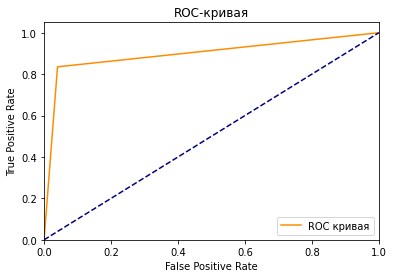

In [16]:
lr_probs = lr_predict_test[: 1]
fpr, tpr, thresholds = metrics.roc_curve(target_test, lr_predict_test, pos_label=1)
lr_auc = metrics.auc(fpr, tpr)
print('ROC AUC =', round(lr_auc,4))

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

Выбранная модель предсказывает адекватно.